In [1]:
# Practice getting NFL data and making data tables

In [2]:
from sportsipy.nfl.schedule import Schedule
from sportsipy.nfl.teams import Teams
import pandas as pd
from sportsipy.nfl.boxscore import Boxscores, Boxscore
from datetime import date
import requests
from bs4 import BeautifulSoup
import re
from keras.models import Sequential
from keras.layers import LSTM, Dense
import seaborn as sns
import sports
from sklearn.model_selection import train_test_split 
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [3]:
teams = Teams()
df = pd.DataFrame(columns = ['Name', 'Abbreviation', 'Penalties', 'Wins', 'Pass Attempts', 'Rush Attempts', 'First Downs',
                            'Turnovers', 'Strength of Schedule', 'Rushing Yards', 'Passing Yards', 'Fumbles', 'Interceptions'])

df['Name'] = [x.name for x in teams]
df['Abbreviation'] = [x.abbreviation for x in teams]
df['Wins'] = [x.wins for x in teams]
df['Penalties'] = [x.penalties for x in teams]
df['Pass Attempts'] = [x.pass_attempts for x in teams]
df['Rush Attempts'] = [x.rush_attempts for x in teams]
df['First Downs'] = [x.first_downs for x in teams]
df['Turnovers'] = [x.turnovers for x in teams]
df['Strength of Schedule'] = [x.strength_of_schedule for x in teams]
df['Rushing Yards'] = [x.rush_yards for x in teams]
df['Passing Yards'] = [x.pass_yards for x in teams]
df['Fumbles'] = [x.fumbles for x in teams]
df['Interceptions'] = [x.interceptions for x in teams]


In [4]:
correlation_data = df[['Wins', 'Pass Attempts', 'Rush Attempts', 'Penalties', 'Turnovers', 'First Downs', 'Strength of Schedule',
                  'Rushing Yards', 'Passing Yards', 'Fumbles', 'Interceptions']]
correlation_data.corr(method ='pearson')

,Wins,Pass Attempts,Rush Attempts,Penalties,Turnovers,First Downs,Strength of Schedule,Rushing Yards,Passing Yards,Fumbles,Interceptions
Wins,1.000000,0.209276,0.331420,-0.144777,-0.420682,0.722811,-0.329122,0.261794,0.672992,-0.228938,-0.399022
Pass Attempts,0.209276,1.000000,-0.515211,0.285037,0.238423,0.495663,0.174189,-0.449771,0.713538,0.119757,0.232071
Rush Attempts,0.331420,-0.515211,1.000000,-0.000904,-0.191038,0.296159,-0.250507,0.837317,-0.216263,-0.108118,-0.178741
Penalties,-0.144777,0.285037,-0.000904,1.000000,0.216950,0.074555,0.164874,-0.013864,0.094409,0.090695,0.222003
Turnovers,-0.420682,0.238423,-0.191038,0.216950,1.000000,-0.123774,0.207486,-0.277198,-0.166562,0.641733,0.890708
First Downs,0.722811,0.495663,0.296159,0.074555,-0.123774,1.000000,-0.154255,0.416908,0.740531,-0.053502,-0.125615
Strength of Schedule,-0.329122,0.174189,-0.250507,0.164874,0.207486,-0.154255,1.000000,-0.255343,-0.125375,0.105204,0.201373
Rushing Yards,0.261794,-0.449771,0.837317,-0.013864,-0.277198,0.416908,-0.255343,1.000000,-0.164692,-0.119401,-0.281568
Passing Yards,0.672992,0.713538,-0.216263,0.094409,-0.166562,0.740531,-0.125375,-0.164692,1.000000,-0.131573,-0.133726
Fumbles,-0.228938,0.119757,-0.108118,0.090695,0.641733,-0.053502,0.105204,-0.119401,-0.131573,1.000000,0.222968


<AxesSubplot:>

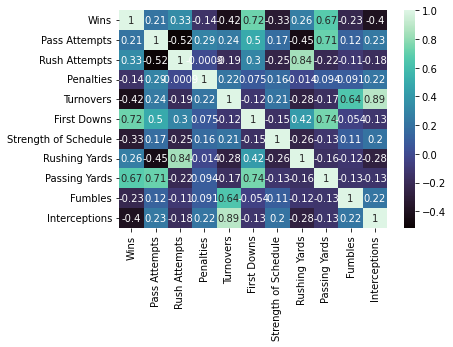

In [5]:
sns.heatmap(correlation_data.corr(), annot=True, cmap="mako")

In [9]:
# creating the date object of today's date
todays_date = date.today()

# web scrape CBS for current week
url = 'https://www.cbssports.com/nfl/schedule/'
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
results = soup.find(id="PageTitle-header").text
try:
    current_week = int(re.search(r'\d+', results).group())
except:
    print('Not in season')

try:
    games_today = Boxscores(current_week, todays_date.year)
except Exception as e:
    print(e)    
# Prints a dictionary of all matchups for week 1 of 2017
# games_today = pd.DataFrame.from_dict(games_today.games)

HTTP Error 404: Not Found


In [7]:
current_schedule = pd.DataFrame(columns = ['Away Team', 'Home Team', 'Away Score', 'Home Score', 'Winner'])

In [8]:
game_date = []


for key in games_today.games.keys():
        current_schedule['Away Team'] =  [item['away_name'] for item in games_today.games[key]]
        current_schedule['Home Team'] =  [item['home_name'] for item in games_today.games[key]]
        current_schedule['Away Score'] =  [item['away_score'] for item in games_today.games[key]]
        current_schedule['Home Score'] =  [item['home_score'] for item in games_today.games[key]]
        current_schedule['Winner'] =  [item['winning_name'] for item in games_today.games[key]]
        game_date.extend(item['boxscore'] for item in games_today.games[key])

NameError: name 'games_today' is not defined

In [ ]:
print(game_date) 

for i in range(len(game_date)):
    game_info = Boxscore(i)
    game_date[i] = game_info.date
    
print(game_date)     

In [ ]:
history_of_seasons = pd.DataFrame(columns = ['Away Team', 'Home Team', 'Away Score', 'Home Score', 'Winner'])

In [ ]:
year = todays_date.year
week = current_week-1
away = []
home = []
away_score = []
home_score = []
winner = []
weeks = []
years = []

while year >= todays_date.year-5:
    if year != todays_date.year: week = 16
    while week >= 1:
        previous_games = Boxscores(week, year)
        for key in previous_games.games.keys():
            away.extend(item['away_name'] for item in previous_games.games[key])
            home.extend(item['home_name'] for item in previous_games.games[key])
            away_score.extend(item['away_score'] for item in previous_games.games[key])
            home_score.extend(item['home_score'] for item in previous_games.games[key])
            winner.extend(item['winning_name'] for item in previous_games.games[key])
            for i in previous_games.games[key]: weeks.append(week)
            for i in previous_games.games[key]: years.append(year)
        week = week-1 
    year = year-1

In [ ]:
home[:] = [x if x != 'Washington Redskins' else 'Washington Football Team' for x in home]
away[:] = [x if x != 'Washington Redskins' else 'Washington Football Team' for x in away]

home[:] = [x if x != 'Oakland Raiders' else 'Las Vegas Raiders' for x in home]
away[:] = [x if x != 'Oakland Raiders' else 'Las Vegas Raiders' for x in away]

history_of_seasons['Away Team'] =  away
history_of_seasons['Home Team'] =  home
history_of_seasons['Away Score'] = away_score
history_of_seasons['Home Score'] =  home_score
history_of_seasons['Winner'] =  winner
history_of_seasons['Week'] =  weeks
history_of_seasons['Season'] =  years

In [ ]:
le = LabelEncoder()

away = le.fit_transform(away)
home = le.fit_transform(home)
winner = le.fit_transform(winner)

data = [away, home, away_score, home_score, weeks, years]
target = [winner]

x = pd.DataFrame(data)
y = pd.DataFrame(target)
x = x.transpose()
y = y.transpose()

print(x.shape)
print(y.shape)

In [ ]:
print(away)

In [ ]:
print(home)

In [ ]:
print(winner)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

In [ ]:
x_train.shape

In [ ]:
# RNN Model
model=Sequential()
model.add(LSTM((1),input_shape=(x_train.shape[1],1)))
model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_test,y_test))